['CT000000', 'CT000001', 'CT000002', 'CT000003', 'CT000004', 'CT000005', 'CT000006', 'CT000007', 'CT000008', 'CT000009', 'CT000010', 'CT000011', 'CT000012', 'CT000013', 'CT000014', 'CT000015', 'CT000016', 'CT000017', 'CT000018', 'CT000019', 'CT000020', 'CT000021', 'CT000022', 'CT000023', 'CT000024', 'CT000025', 'CT000026', 'CT000027', 'CT000028', 'CT000029', 'CT000030', 'CT000031', 'CT000032', 'CT000033', 'CT000034', 'CT000035', 'CT000036', 'CT000037', 'CT000038', 'CT000039', 'CT000040', 'CT000041', 'CT000042', 'CT000043', 'CT000044', 'CT000045', 'CT000046', 'CT000047', 'CT000048', 'CT000049', 'CT000050', 'CT000051', 'CT000052', 'CT000053', 'CT000054', 'CT000055', 'CT000056', 'CT000057', 'CT000058', 'CT000059', 'CT000060', 'CT000061', 'CT000062', 'CT000063', 'CT000064', 'CT000065', 'CT000066', 'CT000067', 'CT000068', 'CT000069', 'CT000070', 'CT000071', 'CT000072', 'CT000073', 'CT000074', 'CT000075', 'CT000076', 'CT000077', 'CT000078', 'CT000079', 'CT000080', 'CT000081', 'CT000082', 'CT

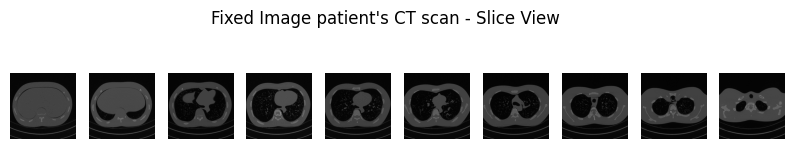

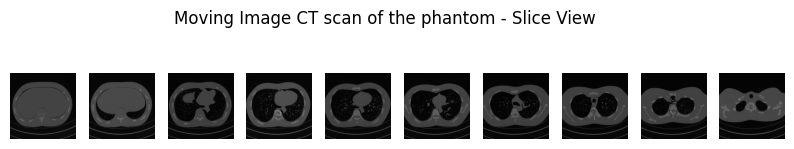

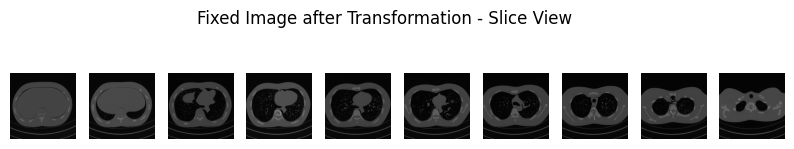

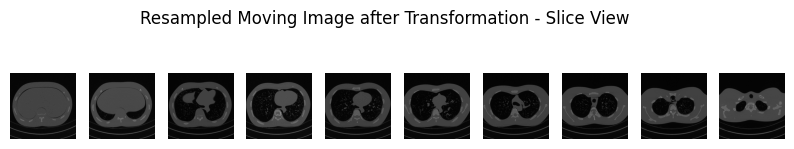

In [1]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ipyvolume as ipv
import SimpleITK as sitk
import ipywidgets as widgets

# Loading the Data
data_path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\SE000003"

# List all files in the directory
files = os.listdir(data_path)
print(files)



def load_dicom_series(directory_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory_path)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return image

def display_images(image, title, montage_slices=10):
    # Convert the SimpleITK image to a numpy array
    image_array = sitk.GetArrayFromImage(image)
    
    # Normalize to 0-255
    image_array = ((image_array - image_array.min()) * (1/(image_array.max() - image_array.min()) * 255)).astype('uint8')
    
    # 3D visualization using ipyvolume
    ipv.figure()
    ipv.volshow(image_array, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=255)
    fig3d = ipv.gcc()
    
    # Create a layout with a title
    title_widget = widgets.HTML(f'<h2>{title} - 3D View</h2>')
    layout = widgets.VBox([title_widget, fig3d])
    display(layout)

    # Montage of slices using matplotlib
    fig = plt.figure(figsize=(10, 2))
    fig.suptitle(title + " - Slice View")
    slice_interval = image_array.shape[0] // montage_slices
    for i in range(montage_slices):
        ax = fig.add_subplot(1, montage_slices, i + 1)
        ax.imshow(image_array[i * slice_interval], cmap='gray')
        plt.axis('off')
    plt.show()


# Paths to the DICOM directories
fixed_image_path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\SE000003"
moving_image_path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\SE000003"

# Load the DICOM images
fixed_image = load_dicom_series(fixed_image_path)
moving_image = load_dicom_series(moving_image_path)

# Display the images with appropriate titles
display_images(fixed_image, "Fixed Image patient's CT scan")
display_images(moving_image, "Moving Image CT scan of the phantom")

# Apply the transformation
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMeanSquares()
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetInterpolator(sitk.sitkLinear)

initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

registration_method.SetInitialTransform(initial_transform, inPlace=False)
final_transform_v1 = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                 sitk.Cast(moving_image, sitk.sitkFloat32))

# Resample the moving image onto the fixed image's grid
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed_image);
resampler.SetTransform(final_transform_v1);
resampled_moving_image = resampler.Execute(moving_image)

# Display the images after transformation
display_images(fixed_image, "Fixed Image after Transformation")
display_images(resampled_moving_image, "Resampled Moving Image after Transformation")


______________________